In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys
pkg_path = "/nfs/homedirs/yuny/project-1/audio_classification"
if pkg_path not in sys.path:
    sys.path.append(pkg_path)

pkg_path = "/nfs/homedirs/yuny/project-1/foolbox"
if pkg_path not in sys.path:
    sys.path.append(pkg_path)

import os
import yaml
import torch
from audio_classification.tools import attack_model, attack_model_for_randomize_smoothing

torch.cuda.empty_cache()
# device = torch.device('cpu')
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
project_dir = '/nfs/homedirs/yuny/project-1/'
save_folder = '/nfs/homedirs/yuny/project-1/attack_results/'

{'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k-audio-rs-0.005', 'SAVE_PATH': '../weights/us8k/', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '../datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'AUGMENTATION': 'none', 'FILE_PATH': '../datasets/UrbanSound8K/audio/', 'NAME': 'UrbanSounds8K', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'VAL_FOLD': 10, 'WEIGHT': 'None'}, 'LOSS': 'cross_entropy', 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': True, 'RANDOMISED_SMOOTHING': True}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 10}, 'SOLVER': {'GAMMA': 0.5, 'LEARNING_RATE': 0.001, 'LOG_PATH': '../logs/us8k/', 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'NUM_GPUS': 1, 'SIGMA': 0.005, 'STEP_SIZE': 25, 'WEIGHT_DECAY': 0.01}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK': True}
Range of the input data is (-1.000000, 1.000000)


/nfs/homedirs/yuny/project-1/foolbox/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 238.66 seconds
tensor([0.8167, 0.7000, 0.3000, 0.3000, 0.3000, 0.2833, 0.2667, 0.2500, 0.2333,
        0.2500, 0.2500, 0.2500, 0.2167, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.1833], dtype=torch.float64)


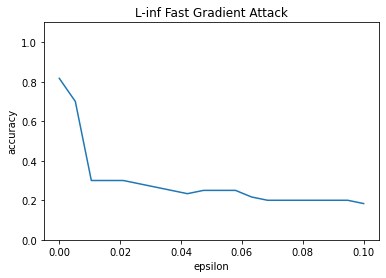

In [2]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 0.1
title = 'us8k_audio_rs_0.005'
config_path = 'logs/us8k/crnn-us8k-audio-rs-0.005/version_0/hparams.yaml'
pretrained_path = 'weights/us8k/crnn-us8k-audio-rs-0.005-epoch=68-val_acc=0.791.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k-audio-rs-0.01', 'SAVE_PATH': '../weights/us8k/', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '../datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'AUGMENTATION': 'none', 'FILE_PATH': '../datasets/UrbanSound8K/audio/', 'NAME': 'UrbanSounds8K', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'VAL_FOLD': 10, 'WEIGHT': 'None'}, 'LOSS': 'cross_entropy', 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': True, 'RANDOMISED_SMOOTHING': True}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 10}, 'SOLVER': {'GAMMA': 0.5, 'LEARNING_RATE': 0.001, 'LOG_PATH': '../logs/us8k/', 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'NUM_GPUS': 1, 'SIGMA': 0.01, 'STEP_SIZE': 25, 'WEIGHT_DECAY': 0.01}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK': True}
Range of the input data is (-1.000000, 1.000000)


/nfs/homedirs/yuny/project-1/foolbox/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 240.08 seconds
tensor([0.8167, 0.8000, 0.8000, 0.8000, 0.7833, 0.7500, 0.7500, 0.7333, 0.7333,
        0.7333, 0.7167, 0.6833, 0.6333, 0.5500, 0.4000, 0.2833, 0.2000, 0.1667,
        0.1500, 0.1500], dtype=torch.float64)


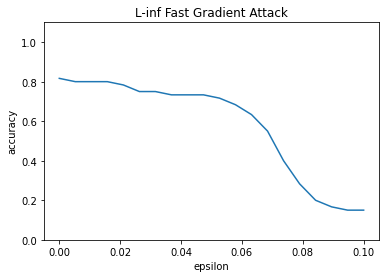

In [5]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 0.1
title = 'us8k_audio_rs_0.01'
config_path = 'logs/us8k/crnn-us8k-audio-rs-0.01/version_0/hparams.yaml'
pretrained_path = 'weights/us8k/crnn-us8k-audio-rs-0.01-epoch=107-val_acc=0.789.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

{'CHECKPOINT': {'SAVE_NAME': 'crnn-us8k-audio-rs-0.05', 'SAVE_PATH': '../weights/us8k/', 'SAVE_TOP_K': 1}, 'DATALOADER': {'BATCH_SIZE': 12, 'NUM_WORKERS': 20}, 'DATASET': {'ANNOTATION_PATH': '../datasets/UrbanSound8K/metadata/UrbanSound8K.csv', 'AUGMENTATION': 'none', 'FILE_PATH': '../datasets/UrbanSound8K/audio/', 'NAME': 'UrbanSounds8K', 'NOISE_PATH': '../datasets/MUSAN/free-sound/', 'VAL_FOLD': 10, 'WEIGHT': 'None'}, 'LOSS': 'cross_entropy', 'MODEL': {'CRNN': {'INCLUDE_TOP': True, 'INCLUDE_TRANSFORM': True, 'RANDOMISED_SMOOTHING': True}, 'NAME': 'LitCRNN', 'NUM_CLASSES': 10}, 'SOLVER': {'GAMMA': 0.5, 'LEARNING_RATE': 0.001, 'LOG_PATH': '../logs/us8k/', 'MAX_EPOCH': 150, 'MIN_EPOCH': 1, 'NUM_GPUS': 1, 'SIGMA': 0.05, 'STEP_SIZE': 25, 'WEIGHT_DECAY': 0.01}, 'TRANSFORM': {'HOP_LENGTH': 256}, 'ATTACK': True}
Range of the input data is (-1.000000, 1.000000)


/nfs/homedirs/yuny/project-1/foolbox/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


Generated attacks in 240.20 seconds
tensor([0.1167, 0.1167, 0.1167, 0.1000, 0.0833, 0.0833, 0.0667, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0333, 0.0333, 0.0333, 0.0333, 0.0333, 0.0167,
        0.0167, 0.0167], dtype=torch.float64)


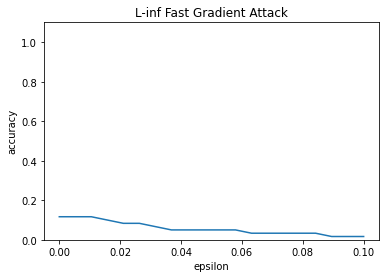

In [6]:
torch.cuda.empty_cache()
project="UrbanSound8k"
max_rad = 0.1
title = 'us8k_audio_rs_0.05'
config_path = 'logs/us8k/crnn-us8k-audio-rs-0.05/version_0/hparams.yaml'
pretrained_path = 'weights/us8k/crnn-us8k-audio-rs-0.05-epoch=129-val_acc=0.701.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'linf', max_radius=max_rad, save_folder=save_folder)

In [ ]:
torch.cuda.empty_cache()
project="BMW"
max_rad = 0.1
title = 'bmw_audio_rs_0.005'
config_path = 'logs/bmw/crnn-bmw-audio-rs-0.005/version_0/hparams.yaml'
pretrained_path = 'weights/bmw/crnn-bmw-audio-rs-0.005-epoch=31-val_acc=1.000.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'l2', max_radius=max_rad, save_folder=save_folder)

In [ ]:
project="BMW"
max_rad = 0.1
title = 'bmw_audio_rs_0.01'
config_path = 'logs/bmw/crnn-bmw-audio-rs-0.01/version_0/hparams.yaml'
pretrained_path = 'weights/bmw/crnn-bmw-audio-rs-0.01-epoch=90-val_acc=0.951.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'l2', max_radius=max_rad, save_folder=save_folder)

In [ ]:
project="BMW"
max_rad = 0.1
title = 'bmw_audio_rs_0.05'
config_path = 'logs/bmw/crnn-bmw-audio-rs-1-new/version_1_rs_0.05/hparams.yaml'
pretrained_path = 'weights/bmw/crnn-bmw-audio-rs-0.05-epoch=71-val_acc=0.934.ckpt'
attack_model_for_randomize_smoothing(project_dir, config_path, pretrained_path, title, 
                                     project=project, attack_type = 'l2', max_radius=max_rad, save_folder=save_folder)